# **Neuropolis: Building an artificial intelligence system for human brain activity prediction (EEG, fMRI)**

#### Version: 10th March 2024

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through nine Notebooks:

*01: fMRI Preprocessing*

*02: EEG Preprocessing*

*03: Linear Regression*

*04: KNN, Decision Trees, Random Forests, SVM*

*05: Neural Networks*

***06: Convolutional Neural Networks***

*07: Recurrent Neural Networks*

*08: Transformers*

*09: Human Brain Predictability Map*

==============================================================================================

### Notebook 06

# **Convolutional Neural Networks**

## **1. Classification**

- **Task**: We train a convolutional neural network model on a classification task, on all subjects except sub-xp102 who has a missing condition. Specifically, our objective is to predict the block type, task or rest. The succession of block types is the same for all subjects and all conditions. 

- **Model**: We use a succession of Conv1D layers with the Stochastic Gradient Descent (SGD) optimizer and the categorical cross-entropy loss. Our objective is to maximize the classification score. Regarding the features, we use directly the EEG data, instead of the bandpowers or the PSD computed from this data. 

- **Strategy**: We limit ourselves to the Predictor Brains strategy, i.e., we use the eegfmriNF condition as the train set, the eegNF condition as the validation set, and the fmriNF condition as the test set, individually for each subject. 

- **Results**: The convolutional neural network model predicts the block type with a probability higher than the baseline. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import mne
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
# Define the raw data path. 
raw_data_path = '../ds002336-download/'

# Define the preprocessed data path. 
preprocessed_data_path = '../neuropolis_preprocessed_data/'

# Define the results path. 
results_path = '../neuropolis_results/'

In [3]:
# Load the targets and the baseline. 
with open(preprocessed_data_path + 'targets/dict_targets.p', 'rb') as file:
    dict_targets = pickle.load(file)
with open(preprocessed_data_path + 'targets/dict_targets_sequence.p', 'rb') as file:
    dict_targets_sequence = pickle.load(file)
with open(preprocessed_data_path + 'baseline/dict_baseline_sequence.p', 'rb') as file:
    dict_baseline_sequence = pickle.load(file)

In [4]:
# Define the list of subjects. 
subjects = ['sub-xp1' + str(x).zfill(2) for x in range(1, 11)]
subject = subjects[0]

# Retrieve the list of all targets. 
targets = list(dict_targets[subject]['eegfmriNF'].keys())

# Select a sequence length. 
selected_sequence_length = 5

# Retrieve the total number of scans. 
nb_scans_total = dict_targets[subject]['eegfmriNF']['pgACC'].shape[0]

# Define the batch size for the neural networks models. 
batch_size = 32

In [5]:
# Define the path of the header file (.vhdr) for an example subject, for the eegfmriNF condition. 
vhdr_path = raw_data_path + 'derivatives/' + subject + '/eeg_pp/' + subject + '_task-eegfmriNF_eeg_pp.vhdr'

# Load the EEG data using the MNE library. 
channels_data = mne.io.read_raw_brainvision(vhdr_path, misc = ['ECG'], preload = True, verbose = False)

/var/folders/8y/sg28phf55jv3mkr_l1g50xn40000gn/T/ipykernel_6608/2277937092.py:5: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  channels_data = mne.io.read_raw_brainvision(vhdr_path, misc = ['ECG'], preload = True, verbose = False)


In [6]:
# Retrieve and display the number of channels. 
nb_channels = len(channels_data.ch_names)
nb_channels

64

In [7]:
# Retrieve and display the sampling frequency. 
sampling_frequency = channels_data.info['sfreq']
sampling_frequency

200.0

In [8]:
# Define the number of scans, and the scan duration in seconds. 
nb_scans = 200
scan_duration = 2 # In seconds. 

# Compute and display the sampling window, i.e., the number of data points during each scan duration. 
sampling_window = int(scan_duration * sampling_frequency)
sampling_window

400

In [9]:
# Compute and display the sequence window, i.e., the number of data points during each sequence duration (including the current scan). 
sequence_window = (sampling_window * selected_sequence_length) + sampling_window
sequence_window

2400

In [10]:
# Define the dictionaries and the summary DataFrame for storing the features. 
dict_features_basis = dict()
dict_features_sequence = dict()
df_summary_global = pd.DataFrame()

In [11]:
%%capture
# The magic command above hides all outputs from this cell. 

# Iterate through all subjects. 
for subject in subjects:
        
    # Define the subject dictionaries. 
    dict_features_basis[subject] = dict()
    dict_features_sequence[subject] = dict()

    # Iterate through all conditions. 
    for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:

        # Skip the current iteration for sub-xp102 and eegNF, since that run is missing. 
        if subject == 'sub-xp102' and condition == 'eegNF':
            continue

        # Load and extract the EEG data in the general features array (2D). Dimensions: data points, channels. 
        vhdr_path = raw_data_path + 'derivatives/' + subject + '/eeg_pp/' + subject + '_task-' + condition + '_eeg_pp.vhdr'
        channels_data = mne.io.read_raw_brainvision(vhdr_path, misc = ['ECG'], preload = True, verbose = False)
        np_channels_data = channels_data.get_data()
        X_basis = np_channels_data.reshape((np_channels_data.shape[1], np_channels_data.shape[0]))

        # Define the particular features array (3D). Dimensions: scans, data points, channels. 
        X_sequence = np.zeros((nb_scans_total - selected_sequence_length, sequence_window, X_basis.shape[1]))
        for scan in range(nb_scans_total - selected_sequence_length):
            X_sequence[scan, :, :] = X_basis[(scan * sampling_window):((scan * sampling_window) + sequence_window), :]

        # Store the features in the dictionaries. 
        dict_features_basis[subject][condition] = X_basis
        dict_features_sequence[subject][condition] = X_sequence

        # Store the shapes of the arrays in the DataFrame. 
        df_summary_global.loc[subject + '/' + condition, 'subject'] = subject
        df_summary_global.loc[subject + '/' + condition, 'condition'] = condition
        df_summary_global.loc[subject + '/' + condition, 'X_basis.shape'] = str(X_basis.shape)
        df_summary_global.loc[subject + '/' + condition, 'X_sequence.shape'] = str(X_sequence.shape)

# Change the indexes of the DataFrame. 
df_summary_global = df_summary_global.set_index(['subject', 'condition'])

In [12]:
# Display the summary DataFrame. 
df_summary_global

X_basis.shape X_sequence.shape
subject   condition                               
sub-xp101 eegNF       (80200, 64)  (195, 2400, 64)
          fmriNF      (80200, 64)  (195, 2400, 64)
          eegfmriNF   (80200, 64)  (195, 2400, 64)
sub-xp102 fmriNF      (80200, 64)  (195, 2400, 64)
          eegfmriNF   (80200, 64)  (195, 2400, 64)
sub-xp103 eegNF       (80200, 64)  (195, 2400, 64)
          fmriNF      (80200, 64)  (195, 2400, 64)
          eegfmriNF   (80200, 64)  (195, 2400, 64)
sub-xp104 eegNF       (80200, 64)  (195, 2400, 64)
          fmriNF      (80400, 64)  (195, 2400, 64)
          eegfmriNF   (80400, 64)  (195, 2400, 64)
sub-xp105 eegNF       (80200, 64)  (195, 2400, 64)
          fmriNF      (80200, 64)  (195, 2400, 64)
          eegfmriNF   (80200, 64)  (195, 2400, 64)
sub-xp106 eegNF       (80200, 64)  (195, 2400, 64)
          fmriNF      (80200, 64)  (195, 2400, 64)
          eegfmriNF   (80200, 64)  (195, 2400, 64)
sub-xp107 eegNF       (80200, 64)  (195, 2400, 64)
          fmriNF      (80200, 64)  (195, 2400, 64)
          eegfmriNF   (80200, 64)  (195, 2400, 64)
sub-xp108 eegNF       (80200, 64)  (195, 2400, 64)
          fmriNF      (80200, 64)  (195, 2400, 64)
          eegfmriNF   (80200, 64)  (195, 2400, 64)
sub-xp109 eegNF       (80200, 64)  (195, 2400, 64)
          fmriNF      (80200, 64)  (195, 2400, 64)
          eegfmriNF   (80200, 64)  (195, 2400, 64)
sub-xp110 eegNF       (80200, 64)  (195, 2400, 64)
          fmriNF      (80200, 64)  (195, 2400, 64)
          eegfmriNF   (80200, 64)  (195, 2400, 64)

In [13]:
# Define and display the target for classification. 
y_basis = np.repeat(np.tile([0, 1], 10), 10)
y_sequence = y_basis[selected_sequence_length:]
print(y_sequence)

[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1]


In [14]:
# Create a baseline containing only the most frequent value. 
most_frequent_value = np.bincount(y_sequence.astype(int)).argmax()
neural_networks_baseline = np.sum(y_sequence.astype(int) == most_frequent_value) / y_sequence.shape[0]
neural_networks_baseline

0.5128205128205128

In [15]:
# Redefine the list of subjects, removing sub-xp102 who has a missing condition. 
subjects.remove('sub-xp102')

In [16]:
# Define a function to run a convolutional neural network model for the Predictor Brains strategy, for a classification task. 
def run_convnet_predictor_brains_classification(NeuralNetworkModel, dict_features_sequence, y_sequence):

    # Define the dictionaries and the summary DataFrame. 
    dict_models = dict()
    dict_history = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Clone the Neural Network model. 
        PredictorBrain = tf.keras.models.clone_model(NeuralNetworkModel)

        # Retrieve the features and targets of the train set, validation set, and test set. 
        X_tr = dict_features_sequence[subject]['eegfmriNF']
        X_va = dict_features_sequence[subject]['eegNF']
        X_te = dict_features_sequence[subject]['fmriNF']
        y_tr = y_va = y_te = y_sequence

        # Rescale features variables. 
        X_tr_standardized = np.zeros(X_tr.shape)
        X_va_standardized = np.zeros(X_va.shape)
        X_te_standardized = np.zeros(X_te.shape)
        for channel_index in range(nb_channels):
            scaler = StandardScaler()
            X_tr_standardized[:, channel_index, :] = scaler.fit_transform(X_tr[:, channel_index, :])
            X_va_standardized[:, channel_index, :] = scaler.transform(X_va[:, channel_index, :])
            X_te_standardized[:, channel_index, :] = scaler.transform(X_te[:, channel_index, :])

        # Encode target variable et retrieve the encoding order. 
        y_tr_encoded = np.array(pd.get_dummies(y_tr))
        y_va_encoded = np.array(pd.get_dummies(y_va))
        y_te_encoded = np.array(pd.get_dummies(y_te))
        encoding_order = np.unique(y_te)

        # End training when accuracy stops improving. 
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

        # Define the loss function, optimizer, and metrics to track during training. 
        PredictorBrain.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])

        # Fit the model. 
        NeuralNetworkHistory = PredictorBrain.fit(
            x = X_tr_standardized, y = y_tr_encoded,
            validation_data = (X_va_standardized, y_va_encoded), 
            batch_size = batch_size, epochs = 30,
            shuffle = True, callbacks = [early_stopping], verbose = 0
        )

        # Evaluate the test score. 
        (loss_test, score_test) = PredictorBrain.evaluate(X_te_standardized, y_te_encoded, batch_size = batch_size)

        # Compute the predictions from the neural network, and compute the accuracy from these predictions. 
        y_pred = encoding_order[np.where(PredictorBrain.predict(X_te_standardized) > 0.5)[1]]

        # Store the performance metrics and the shapes of the arrays in the DataFrame. 
        df_summary.loc[subject, 'loss_train'] = NeuralNetworkHistory.history['loss'][-1]
        df_summary.loc[subject, 'loss_valid'] = NeuralNetworkHistory.history['val_loss'][-1]
        df_summary.loc[subject, 'loss_test'] = loss_test
        df_summary.loc[subject, 'score_train'] = NeuralNetworkHistory.history['acc'][-1]
        df_summary.loc[subject, 'score_valid'] = NeuralNetworkHistory.history['val_acc'][-1]
        df_summary.loc[subject, 'score_test'] = score_test
        df_summary.loc[subject, 'score_baseline'] = neural_networks_baseline
        df_summary.loc[subject, 'above_baseline'] = str(score_test > neural_networks_baseline)
        df_summary.loc[subject, 'X_tr.shape'] = str(X_tr_standardized.shape)
        df_summary.loc[subject, 'X_va.shape'] = str(X_va_standardized.shape)
        df_summary.loc[subject, 'X_te.shape'] = str(X_te_standardized.shape)
        df_summary.loc[subject, 'y_tr.shape'] = str(y_tr_encoded.shape)
        df_summary.loc[subject, 'y_va.shape'] = str(y_va_encoded.shape)
        df_summary.loc[subject, 'y_te.shape'] = str(y_te_encoded.shape)

        # Store the trained model, the model history, and the predictions in the dictionary. 
        dict_models[subject] = PredictorBrain
        dict_history[subject] = NeuralNetworkHistory
        dict_predictions[subject] = y_pred
    
    return dict_models, dict_history, dict_predictions, df_summary

In [17]:
# Define a function to plot the results of the neural network training. 
def plot_neural_network_classification(dict_history_class, title):
    
    # Display the graph. 
    fig, axes = plt.subplots(nrows = 9, ncols = 2, figsize = (12, 52))
    fig.suptitle(title, fontsize = 14, y = 0.895)
    subject_index = 0

    # Iterate through all subjects. 
    for subject in subjects:

        # Retrieve the history. 
        NeuralNetworkHistory = dict_history_class[subject]

        # Plot loss values. 
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['loss'], label = 'train loss', color = 'blue')
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['val_loss'], label = 'val loss', color = 'green')
        axes[subject_index, 0].set_title(str(subject) + ' valid. loss: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_loss'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 0].set_xlabel('Epoch')
        axes[subject_index, 0].set_ylabel('Loss value')
        axes[subject_index, 0].legend()

        # Plot accuracy values. 
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['acc'], label = 'train acc', color = 'blue')
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['val_acc'], label = 'val acc', color = 'green')
        axes[subject_index, 1].set_title(str(subject) + ' valid. accuracy: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_acc'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 1].set_xlabel('Epoch')
        axes[subject_index, 1].set_ylabel('Accuracy')
        axes[subject_index, 1].legend();

        # Increment. 
        subject_index += 1

In [18]:
# Define the neural network model. 
tf.random.set_seed(0)
NeuralNetworkModel = tf.keras.Sequential()

# 1D ConvNet layer. 
NeuralNetworkModel.add(tf.keras.layers.Conv1D(
    filters = 32, 
    kernel_size = 16, strides = 2, 
    activation = tf.keras.activations.relu, 
    data_format = 'channels_last', input_shape = dict_features_sequence[subject]['eegfmriNF'].shape[1:],
    ))
NeuralNetworkModel.add(tf.keras.layers.MaxPool1D(data_format = 'channels_last'))

# 1D ConvNet layer. 
NeuralNetworkModel.add(tf.keras.layers.Conv1D(
    filters = 32, 
    kernel_size = 16, strides = 2, 
    activation = tf.keras.activations.relu, 
    data_format = 'channels_last'
    ))
NeuralNetworkModel.add(tf.keras.layers.MaxPool1D(data_format = 'channels_last'))

# 1D ConvNet layer. 
NeuralNetworkModel.add(tf.keras.layers.Conv1D(
    filters = 64, 
    kernel_size = 8, 
    activation = tf.keras.activations.relu, 
    data_format = 'channels_last'
    ))
NeuralNetworkModel.add(tf.keras.layers.MaxPool1D(data_format = 'channels_last'))

# 1D ConvNet layer. 
NeuralNetworkModel.add(tf.keras.layers.Conv1D(
    filters = 64, 
    kernel_size = 8, 
    activation = tf.keras.activations.relu, 
    data_format = 'channels_last'
    ))
NeuralNetworkModel.add(tf.keras.layers.MaxPool1D(data_format = 'channels_last'))
NeuralNetworkModel.add(tf.keras.layers.Flatten(data_format = 'channels_last'))

# Output layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = 2, activation = tf.keras.activations.softmax,
    kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 1.0, seed = 0)))

# Print network summary. 
NeuralNetworkModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1193, 32)          32800     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 596, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 291, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 145, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 138, 64)           16448     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 69, 64)           0

In [19]:
# Run the convolutional neural network model. 
dict_models_pb_class, dict_history_pb_class, dict_predictions_pb_class, df_summary_pb_class = run_convnet_predictor_brains_classification(NeuralNetworkModel, 
                                                                                                                                          dict_features_sequence, 
                                                                                                                                          y_sequence)

sub-xp101


2024-03-10 13:50:52.432097: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7/7 [==============================] - 0s 8ms/step
sub-xp103
7/7 [==============================] - 0s 9ms/step
sub-xp104
7/7 [==============================] - 0s 8ms/step
sub-xp105
7/7 [==============================] - 0s 9ms/step
sub-xp106
7/7 [==============================] - 0s 9ms/step
sub-xp107
7/7 [==============================] - 0s 10ms/step
sub-xp108
7/7 [==============================] - 0s 9ms/step
sub-xp109
7/7 [==============================] - 0s 10ms/step
sub-xp110
7/7 [==============================] - 0s 10ms/step


In [20]:
# Display the results. 
print('Convolutional Neural Networks: Predictor Brains, Classification')
df_summary_pb_class

Convolutional Neural Networks: Predictor Brains, Classification


,loss_train,loss_valid,loss_test,score_train,score_valid,score_test,score_baseline,above_baseline,X_tr.shape,X_va.shape,X_te.shape,y_tr.shape,y_va.shape,y_te.shape
sub-xp101,0.690866,0.692290,0.692466,0.528205,0.533333,0.533333,0.512821,True,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 2)","(195, 2)","(195, 2)"
sub-xp103,0.688645,0.687894,0.690025,0.548718,0.543590,0.528205,0.512821,True,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 2)","(195, 2)","(195, 2)"
sub-xp104,0.692354,0.693649,0.692943,0.517949,0.512821,0.512821,0.512821,True,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 2)","(195, 2)","(195, 2)"
sub-xp105,0.690344,0.691480,0.691763,0.543590,0.533333,0.533333,0.512821,True,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 2)","(195, 2)","(195, 2)"
sub-xp106,0.687149,0.686825,0.687843,0.538462,0.533333,0.517949,0.512821,True,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 2)","(195, 2)","(195, 2)"
sub-xp107,0.686028,0.689211,0.686917,0.543590,0.523077,0.538462,0.512821,True,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 2)","(195, 2)","(195, 2)"
sub-xp108,0.689091,0.689480,0.689359,0.548718,0.523077,0.574359,0.512821,True,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 2)","(195, 2)","(195, 2)"
sub-xp109,0.689711,0.689748,0.689537,0.533333,0.533333,0.538462,0.512821,True,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 2)","(195, 2)","(195, 2)"
sub-xp110,0.690610,0.691229,0.690607,0.533333,0.533333,0.533333,0.512821,True,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 2)","(195, 2)","(195, 2)"


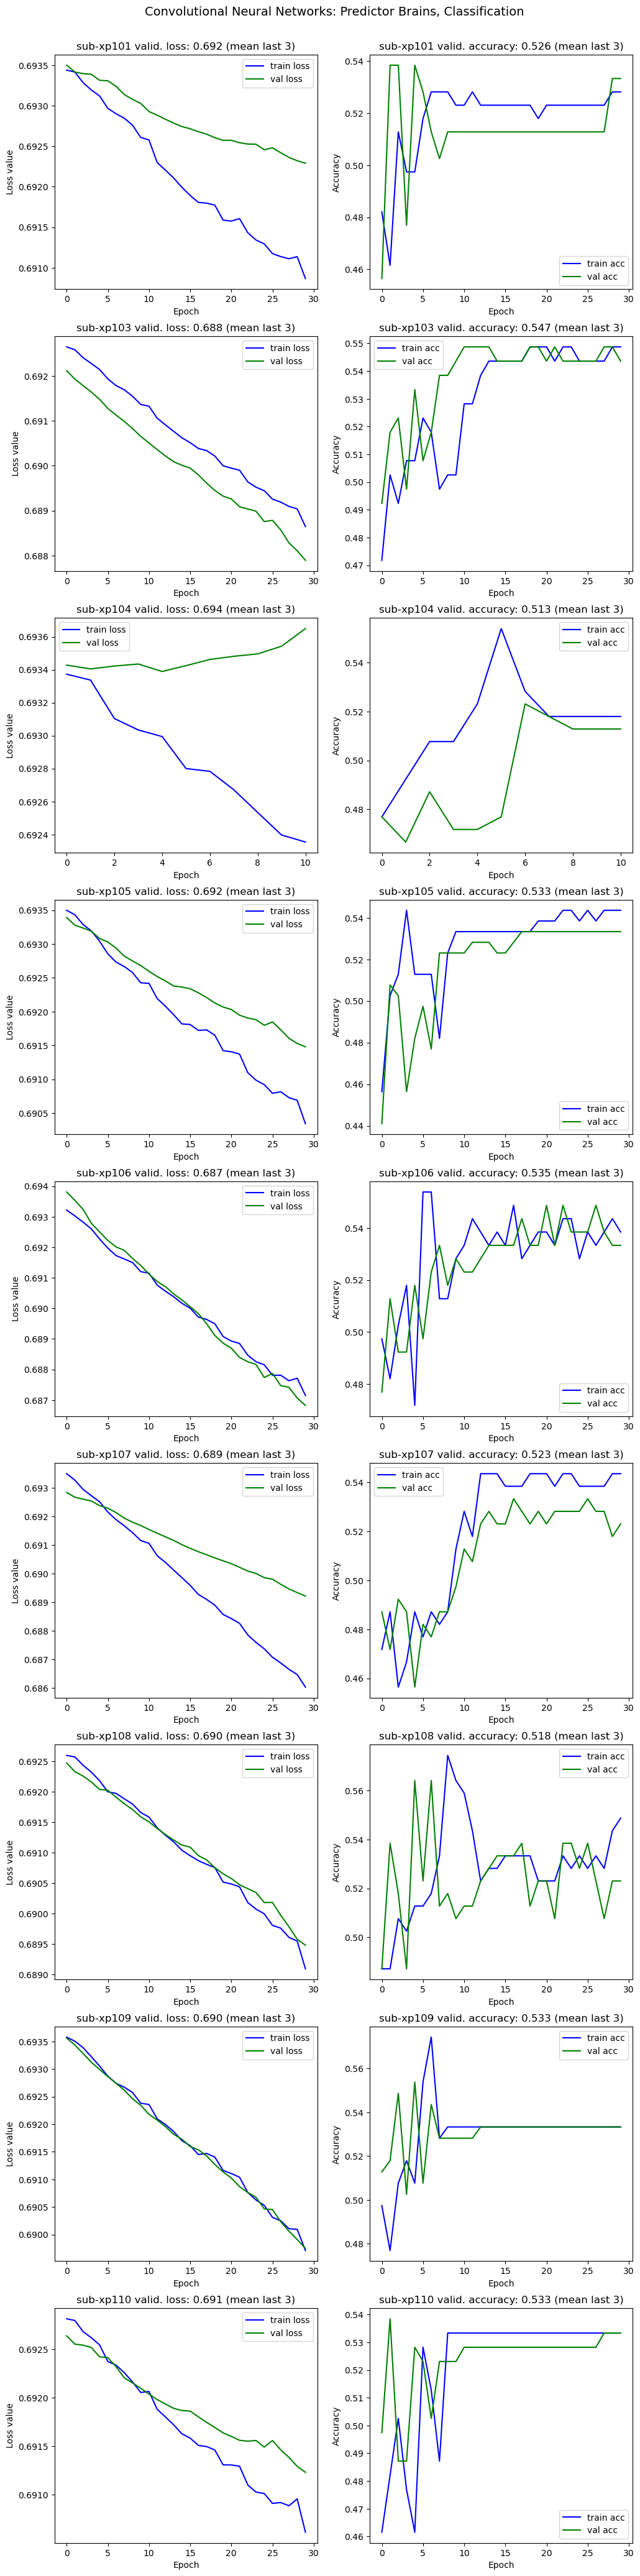

In [21]:
# Display the results. 
plot_neural_network_classification(dict_history_pb_class, title = 'Convolutional Neural Networks: Predictor Brains, Classification')

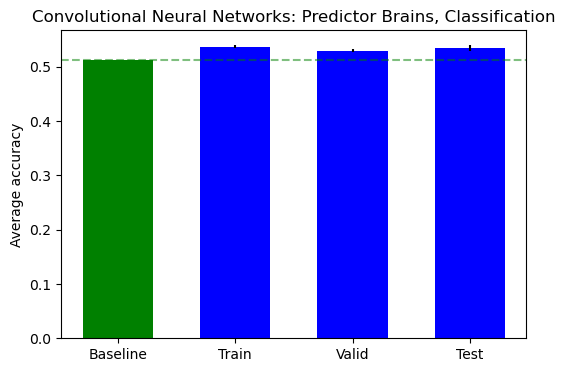

In [22]:
# Retrieve the average accuracy and the standard error of the accuracy. 
acc = [df_summary_pb_class['score_baseline'].mean(), 
       df_summary_pb_class['score_train'].mean(), 
       df_summary_pb_class['score_valid'].mean(), 
       df_summary_pb_class['score_test'].mean()]
acc_se = [np.std(df_summary_pb_class['score_baseline']) / np.sqrt(df_summary_pb_class['score_baseline'].shape[0]), 
          np.std(df_summary_pb_class['score_train']) / np.sqrt(df_summary_pb_class['score_train'].shape[0]), 
          np.std(df_summary_pb_class['score_valid']) / np.sqrt(df_summary_pb_class['score_valid'].shape[0]), 
          np.std(df_summary_pb_class['score_test']) / np.sqrt(df_summary_pb_class['score_test'].shape[0])]

# Display the average accuracy and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
axes.bar(range(4), acc, width = 0.6, color = ['green', 'blue', 'blue', 'blue'])
axes.errorbar(range(4), acc, yerr = acc_se, fmt = 'None', color = 'black')
axes.axhline(acc[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(4), labels = ['Baseline', 'Train', 'Valid', 'Test'])
axes.set_ylabel('Average accuracy')
axes.set_title('Convolutional Neural Networks: Predictor Brains, Classification');

## **2. Regression**

- **Task**: We train a convolutional neural network model on our regression task of interest, on all subjects except sub-xp102 who has a missing condition. 

- **Model**: We use mostly the same model than for the classification task, but with the Adam optimizer and the Mean Squared Error (MSE) loss. Our objective is to minimize the regression Mean Absolute Error (MAE). Again, regarding the features, we use directly the EEG data, instead of the bandpowers or the PSD computed from this data. 

- **Strategy**: The Predictor Brains strategy is defined as in the classification task. 

- **Results**: The convolutional neural network model typically beats the baseline for the train set and the validation set, but stays at the baseline level for the test set, indicating a lack of generalization. The predictions are essentially similar to the baseline, with a few outliers probably caused by extreme values in the EEG data. 

In [23]:
# Define the Mean Squared Error function. 
def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))

In [24]:
# Define the Mean Absolute Error function. 
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [25]:
# Define the Residual Sum of Squares function. 
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

In [26]:
# Define a function to run a convolutional neural network model for the Predictor Brains strategy, for a regression task. 
def run_convnet_predictor_brains_regression(NeuralNetworkModel, dict_features_sequence, dict_targets_sequence, dict_baseline_sequence):

    # Define the dictionaries and the summary DataFrame. 
    dict_models = dict()
    dict_history = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Clone the Neural Network model. 
        PredictorBrain = tf.keras.models.clone_model(NeuralNetworkModel)

        # Retrieve the features of the train set, validation set, and test set. 
        X_tr = dict_features_sequence[subject]['eegfmriNF']
        X_va = dict_features_sequence[subject]['eegNF']
        X_te = dict_features_sequence[subject]['fmriNF']

        # Retrieve the targets of the train set, validation set, and test set. 
        Y_tr = dict_targets_sequence[subject]['eegfmriNF']
        Y_va = dict_targets_sequence[subject]['eegNF']
        Y_te = dict_targets_sequence[subject]['fmriNF']

        # Retrieve the baseline of the train set. 
        Baseline = dict_baseline_sequence[subject]['eegfmriNF']

        # Rescale features variables. 
        X_tr_standardized = np.zeros(X_tr.shape)
        X_va_standardized = np.zeros(X_va.shape)
        X_te_standardized = np.zeros(X_te.shape)
        for channel_index in range(nb_channels):
            scaler = StandardScaler()
            X_tr_standardized[:, channel_index, :] = scaler.fit_transform(X_tr[:, channel_index, :])
            X_va_standardized[:, channel_index, :] = scaler.transform(X_va[:, channel_index, :])
            X_te_standardized[:, channel_index, :] = scaler.transform(X_te[:, channel_index, :])

        # End training when accuracy stops improving. 
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

        # Define the loss function, optimizer, and metrics to track during training. 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001)
        PredictorBrain.compile(optimizer = optimizer, loss = 'mse', metrics = [tf.keras.metrics.MeanAbsoluteError()])

        # Fit the model. 
        NeuralNetworkHistory = PredictorBrain.fit(
            x = X_tr_standardized, y = Y_tr,
            validation_data = (X_va_standardized, Y_va), 
            batch_size = batch_size, epochs = 30, 
            shuffle = True, callbacks = [early_stopping], verbose = 0
        )

        # Evaluate the test score. 
        (mse_test, mae_test) = PredictorBrain.evaluate(X_te_standardized, Y_te, batch_size = batch_size)

        # Compute the predictions from the neural network, and compute the accuracy from these predictions. 
        Y_pred = PredictorBrain.predict(X_te_standardized)

        # Evaluate the performance metrics. 
        mse_baseline = MSE(Y_te, Baseline)
        mae_baseline = MAE(Y_te, Baseline)
        rss_baseline = RSS(Y_te, Baseline)
        mse_model = MSE(Y_te, Y_pred)
        mae_model = MAE(Y_te, Y_pred)
        rss_model = RSS(Y_te, Y_pred)
        r2_model = 1 - (rss_model / rss_baseline)

        # Store the performance metrics and the shapes of the arrays in the DataFrame. 
        df_summary.loc[subject, 'mse_train'] = NeuralNetworkHistory.history['loss'][-1]
        df_summary.loc[subject, 'mse_valid'] = NeuralNetworkHistory.history['val_loss'][-1]
        df_summary.loc[subject, 'mse_test'] = mse_test
        df_summary.loc[subject, 'mae_train'] = NeuralNetworkHistory.history['mean_absolute_error'][-1]
        df_summary.loc[subject, 'mae_valid'] = NeuralNetworkHistory.history['val_mean_absolute_error'][-1]
        df_summary.loc[subject, 'mae_test'] = mae_test
        df_summary.loc[subject, 'mae_baseline'] = mae_baseline
        df_summary.loc[subject, 'r2_model'] = r2_model
        df_summary.loc[subject, 'X_tr.shape'] = str(X_tr_standardized.shape)
        df_summary.loc[subject, 'X_va.shape'] = str(X_va_standardized.shape)
        df_summary.loc[subject, 'X_te.shape'] = str(X_te_standardized.shape)
        df_summary.loc[subject, 'Y_tr.shape'] = str(Y_tr.shape)
        df_summary.loc[subject, 'Y_va.shape'] = str(Y_va.shape)
        df_summary.loc[subject, 'Y_te.shape'] = str(Y_te.shape)

        # Store the trained model, the model history, and the predictions in the dictionary. 
        dict_models[subject] = PredictorBrain
        dict_history[subject] = NeuralNetworkHistory
        dict_predictions[subject] = Y_pred
    
    return dict_models, dict_history, dict_predictions, df_summary

In [27]:
# Define a function to plot the results of the neural network training. 
def plot_neural_network_regression(dict_history_reg, title):
    
    # Display the graph. 
    fig, axes = plt.subplots(nrows = 9, ncols = 2, figsize = (12, 52))
    fig.suptitle(title, fontsize = 14, y = 0.895)
    subject_index = 0

    # Iterate through all subjects. 
    for subject in subjects:

        # Retrieve the history. 
        NeuralNetworkHistory = dict_history_reg[subject]

        # Plot MSE values. 
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['loss'], label = 'train MSE', color = 'blue')
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['val_loss'], label = 'val MSE', color = 'green')
        axes[subject_index, 0].set_title(str(subject) + ' valid. MSE: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_loss'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 0].set_xlabel('Epoch')
        axes[subject_index, 0].set_ylabel('MSE')
        axes[subject_index, 0].legend()

        # Plot MAE values. 
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['mean_absolute_error'], label = 'train MAE', color = 'blue')
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['val_mean_absolute_error'], label = 'val MAE', color = 'green')
        axes[subject_index, 1].set_title(str(subject) + ' valid. MAE: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_mean_absolute_error'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 1].set_xlabel('Epoch')
        axes[subject_index, 1].set_ylabel('MAE')
        axes[subject_index, 1].legend();

        # Increment. 
        subject_index += 1

In [28]:
# Define the neural network model. 
tf.random.set_seed(0)
NeuralNetworkModel = tf.keras.Sequential()

# 1D ConvNet layer. 
NeuralNetworkModel.add(tf.keras.layers.Conv1D(
    filters = 32, 
    kernel_size = 16, strides = 2, 
    activation = tf.keras.activations.relu, 
    data_format = 'channels_last', input_shape = dict_features_sequence[subject]['eegfmriNF'].shape[1:],
    ))
NeuralNetworkModel.add(tf.keras.layers.MaxPool1D(data_format = 'channels_last'))

# 1D ConvNet layer. 
NeuralNetworkModel.add(tf.keras.layers.Conv1D(
    filters = 32, 
    kernel_size = 16, strides = 2, 
    activation = tf.keras.activations.relu, 
    data_format = 'channels_last'
    ))
NeuralNetworkModel.add(tf.keras.layers.MaxPool1D(data_format = 'channels_last'))

# 1D ConvNet layer. 
NeuralNetworkModel.add(tf.keras.layers.Conv1D(
    filters = 64, 
    kernel_size = 8, 
    activation = tf.keras.activations.relu, 
    data_format = 'channels_last'
    ))
NeuralNetworkModel.add(tf.keras.layers.MaxPool1D(data_format = 'channels_last'))

# 1D ConvNet layer. 
NeuralNetworkModel.add(tf.keras.layers.Conv1D(
    filters = 64, 
    kernel_size = 8, 
    activation = tf.keras.activations.relu, 
    data_format = 'channels_last'
    ))
NeuralNetworkModel.add(tf.keras.layers.MaxPool1D(data_format = 'channels_last'))
NeuralNetworkModel.add(tf.keras.layers.Flatten(data_format = 'channels_last'))

# Output layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = dict_targets_sequence[subject]['eegfmriNF'].shape[1], 
    ))

# Print network summary. 
NeuralNetworkModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1193, 32)          32800     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 596, 32)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 291, 32)           16416     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 145, 32)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 138, 64)           16448     


                                                                 
 max_pooling1d_6 (MaxPooling  (None, 69, 64)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 62, 64)            32832     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 31, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1984)              0         
                                                                 
 dense_1 (Dense)             (None, 17)                33745     
                                                                 
Total params: 132,241
Trainable params: 132,241
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Run the convolutional neural network model. 
dict_models_pb_reg, dict_history_pb_reg, dict_predictions_pb_reg, df_summary_pb_reg = run_convnet_predictor_brains_regression(NeuralNetworkModel, 
                                                                                                                              dict_features_sequence, 
                                                                                                                              dict_targets_sequence, 
                                                                                                                              dict_baseline_sequence)

sub-xp101
7/7 [==============================] - 0s 7ms/step
sub-xp103
7/7 [==============================] - 0s 9ms/step
sub-xp104
7/7 [==============================] - 0s 10ms/step
sub-xp105
7/7 [==============================] - 0s 9ms/step
sub-xp106
7/7 [==============================] - 0s 9ms/step
sub-xp107
7/7 [==============================] - 0s 9ms/step
sub-xp108
7/7 [==============================] - 0s 9ms/step
sub-xp109
7/7 [==============================] - 0s 11ms/step
sub-xp110
7/7 [==============================] - 0s 10ms/step


In [30]:
# Display the results. 
print('Convolutional Neural Networks: Predictor Brains, Regression')
df_summary_pb_reg

Convolutional Neural Networks: Predictor Brains, Regression


,mse_train,mse_valid,mse_test,mae_train,mae_valid,mae_test,mae_baseline,r2_model,X_tr.shape,X_va.shape,X_te.shape,Y_tr.shape,Y_va.shape,Y_te.shape
sub-xp101,0.905183,0.836287,0.944769,0.765073,0.728253,0.770981,0.761400,-0.034530,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 17)","(195, 17)","(195, 17)"
sub-xp103,0.959649,0.978706,0.974320,0.789517,0.800215,0.794619,0.793431,-0.003623,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 17)","(195, 17)","(195, 17)"
sub-xp104,0.830824,0.876270,0.936272,0.728164,0.729080,0.775601,0.768766,-0.017820,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 17)","(195, 17)","(195, 17)"
sub-xp105,0.929316,0.955966,0.970547,0.781568,0.778047,0.796263,0.788395,-0.019132,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 17)","(195, 17)","(195, 17)"
sub-xp106,0.915086,0.995254,0.979681,0.762644,0.799898,0.802882,0.793431,-0.020036,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 17)","(195, 17)","(195, 17)"
sub-xp107,0.940065,0.991313,0.960829,0.776780,0.793241,0.786383,0.782540,-0.008072,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 17)","(195, 17)","(195, 17)"
sub-xp108,0.953762,0.971216,0.985392,0.779073,0.799734,0.802407,0.799883,-0.005379,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 17)","(195, 17)","(195, 17)"
sub-xp109,0.966734,0.975992,0.967668,0.791988,0.796130,0.797961,0.798910,0.000996,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 17)","(195, 17)","(195, 17)"
sub-xp110,0.950202,0.964698,0.961004,0.778982,0.792051,0.792456,0.790629,-0.007744,"(195, 2400, 64)","(195, 2400, 64)","(195, 2400, 64)","(195, 17)","(195, 17)","(195, 17)"


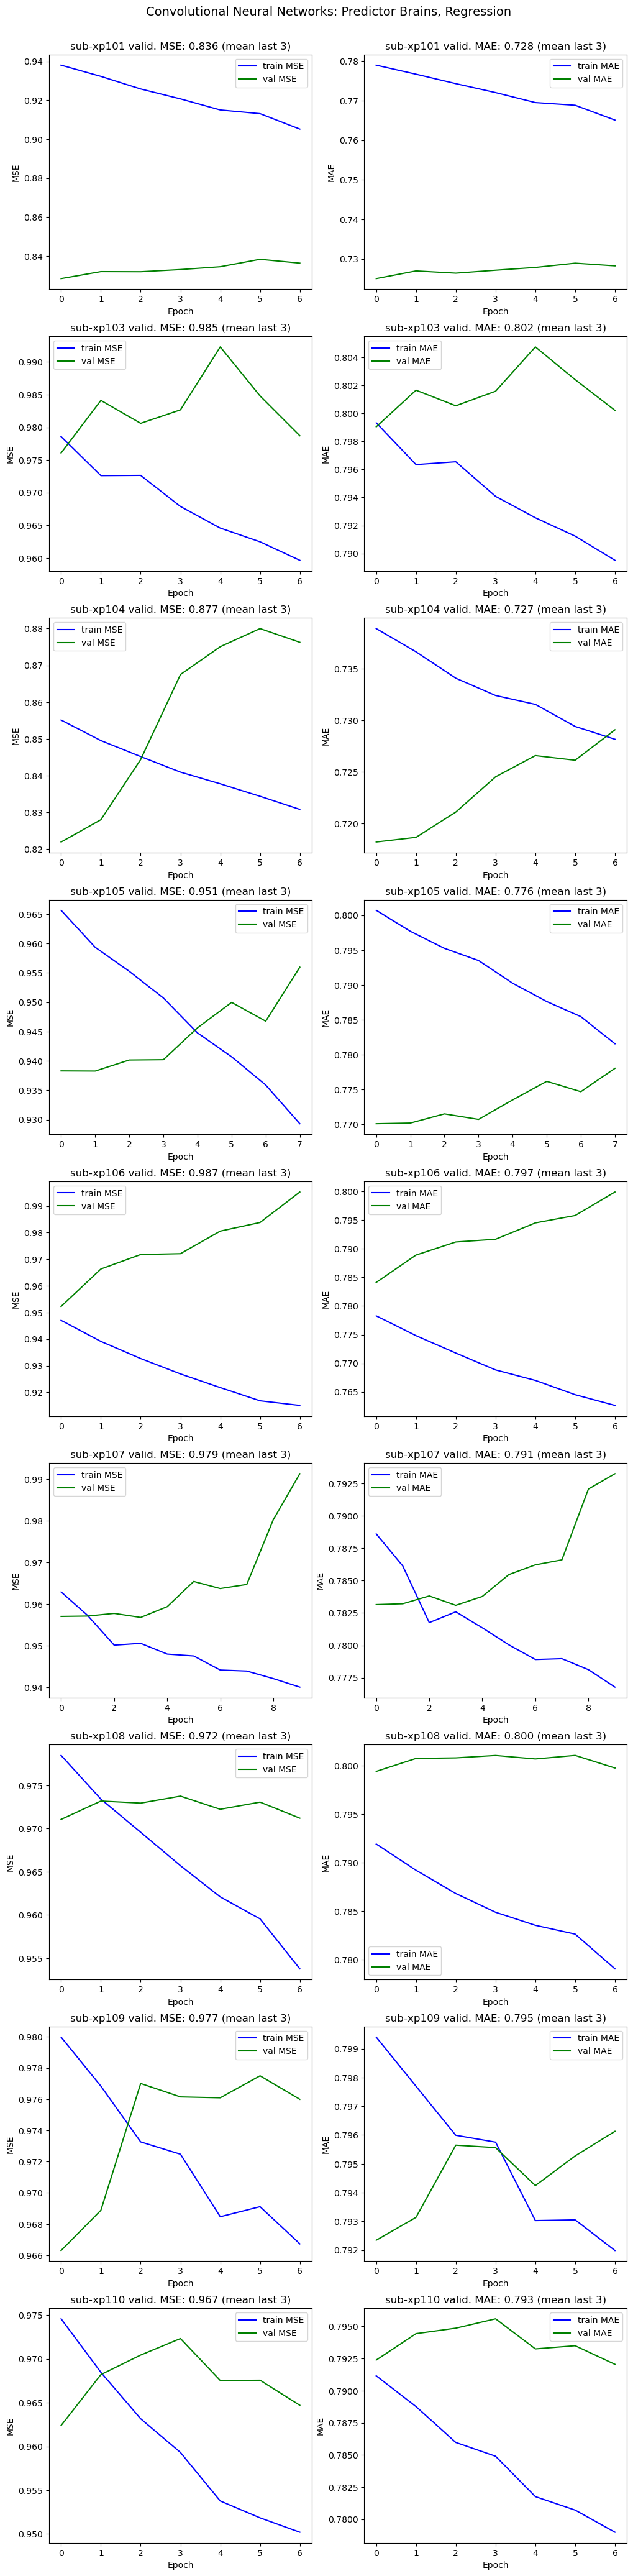

In [31]:
# Display the results. 
plot_neural_network_regression(dict_history_pb_reg, title = 'Convolutional Neural Networks: Predictor Brains, Regression')

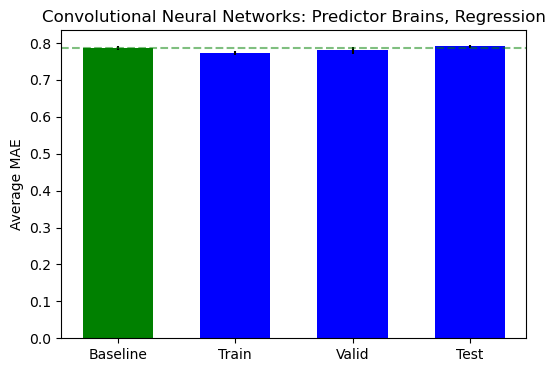

In [32]:
# Retrieve the average MAE and the standard error of the MAE. 
acc = [df_summary_pb_reg['mae_baseline'].mean(), 
       df_summary_pb_reg['mae_train'].mean(), 
       df_summary_pb_reg['mae_valid'].mean(), 
       df_summary_pb_reg['mae_test'].mean()]
acc_se = [np.std(df_summary_pb_reg['mae_baseline']) / np.sqrt(df_summary_pb_reg['mae_baseline'].shape[0]), 
          np.std(df_summary_pb_reg['mae_train']) / np.sqrt(df_summary_pb_reg['mae_train'].shape[0]), 
          np.std(df_summary_pb_reg['mae_valid']) / np.sqrt(df_summary_pb_reg['mae_valid'].shape[0]), 
          np.std(df_summary_pb_reg['mae_test']) / np.sqrt(df_summary_pb_reg['mae_test'].shape[0])]

# Display the average MAE and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
axes.bar(range(4), acc, width = 0.6, color = ['green', 'blue', 'blue', 'blue'])
axes.errorbar(range(4), acc, yerr = acc_se, fmt = 'None', color = 'black')
axes.axhline(acc[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(4), labels = ['Baseline', 'Train', 'Valid', 'Test'])
axes.set_ylabel('Average MAE')
axes.set_title('Convolutional Neural Networks: Predictor Brains, Regression');

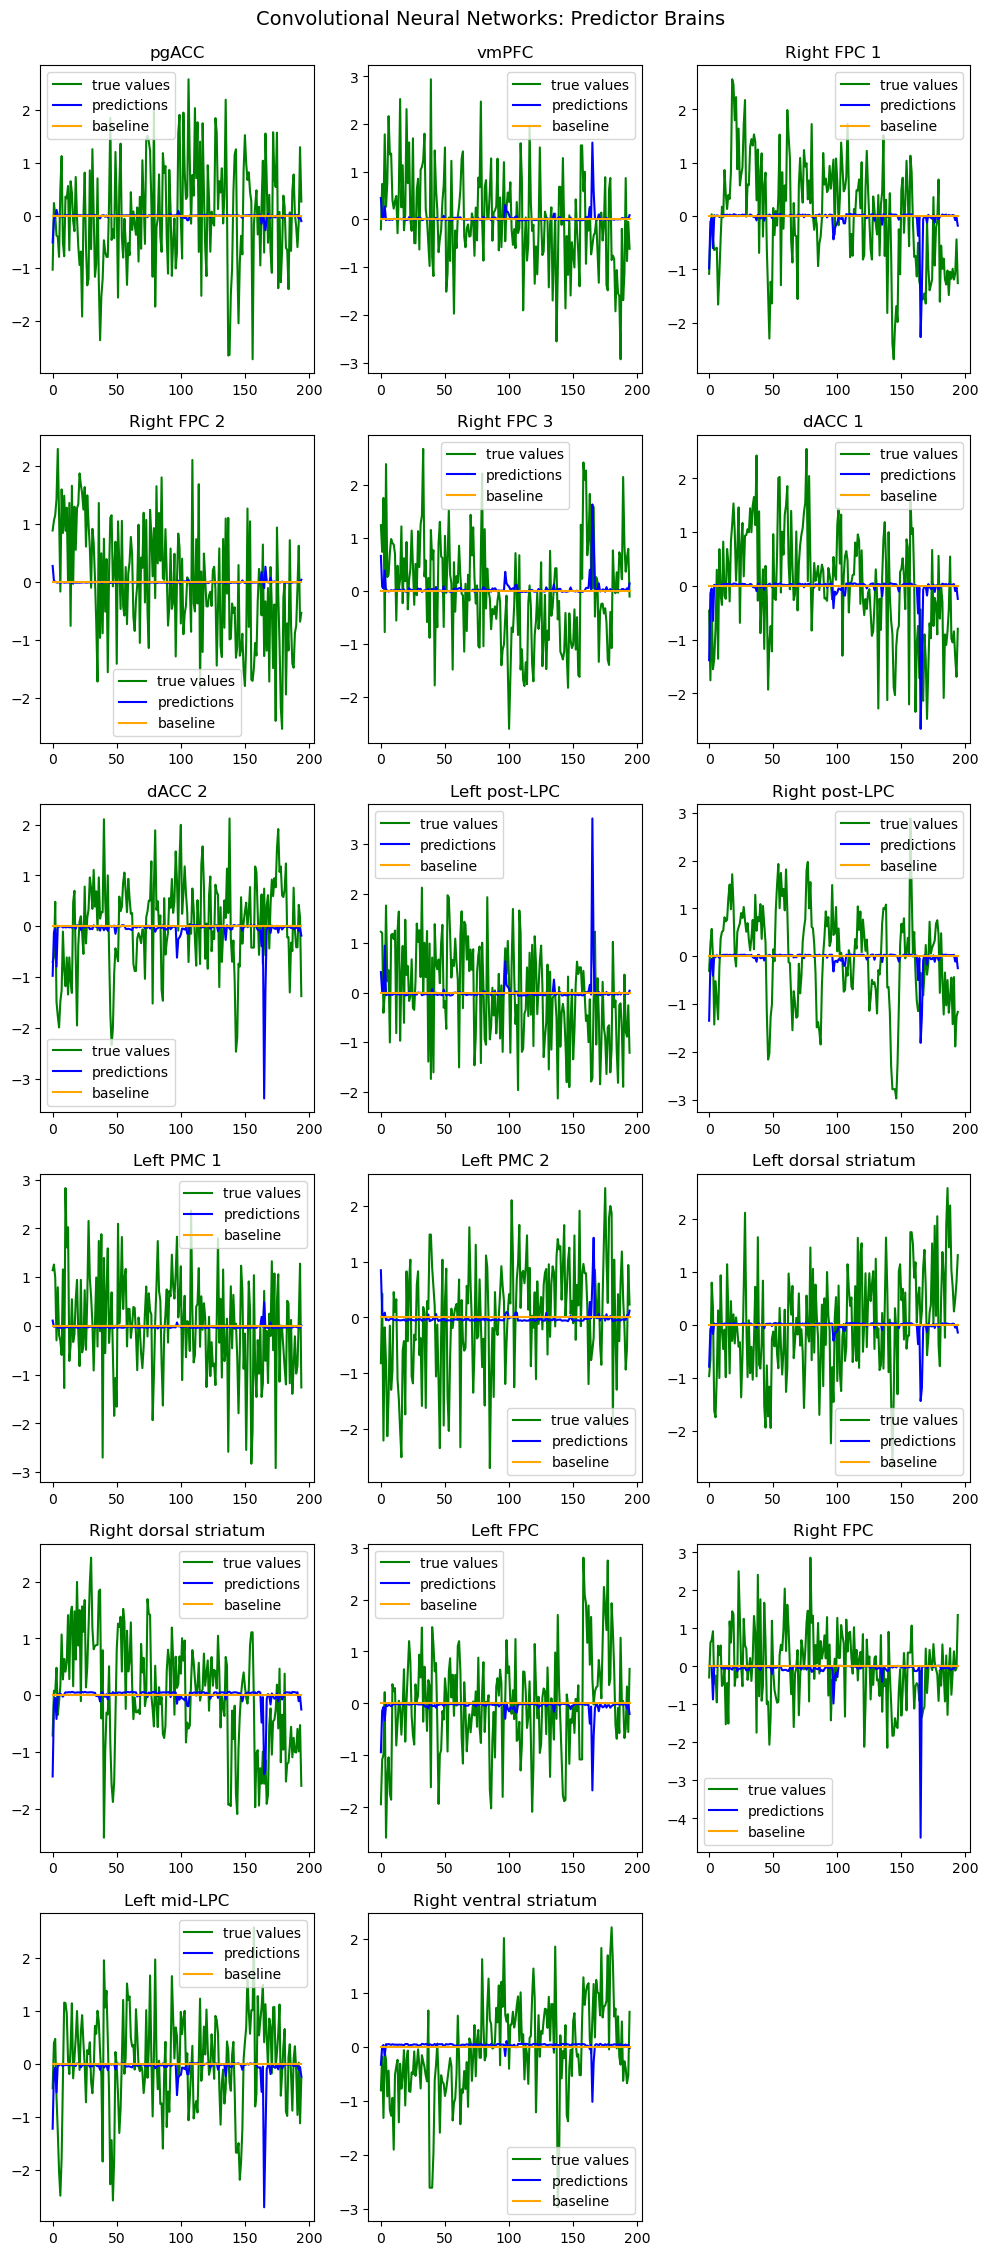

In [33]:
# Plot the true values, the predictions, and the baseline for all the targets voxels. 
fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (12, 28))
fig.suptitle('Convolutional Neural Networks: Predictor Brains', fontsize = 14, y = 0.9)
subject = subjects[0]

# Iterate through all target voxels. 
for target_index in range(len(targets)):

    # Retrieve the true values, the predictions, and the baseline for the selected subject and sequence length. 
    Y_te = dict_targets_sequence[subject]['fmriNF'][:, target_index]
    Y_pred = dict_predictions_pb_reg[subject][:, target_index]
    Baseline = dict_baseline_sequence[subject]['eegfmriNF'][:, target_index]

    # Compute the row and column indexes. 
    row_index = target_index // 3
    column_index = target_index % 3

    # Plot the true values, the predictions, and the baseline. 
    axes[row_index, column_index].plot(Y_te,  color = 'green', label = 'true values')
    axes[row_index, column_index].plot(Y_pred,  color = 'blue', label = 'predictions')
    axes[row_index, column_index].plot(Baseline,  color = 'orange', label = 'baseline')
    axes[row_index, column_index].legend()
    axes[row_index, column_index].set_title(targets[target_index])

# Hide empty subplot. 
axes[5, 2].set_visible(False)

In [34]:
# Save the regression models into a Pickle file. 
with open(results_path + 'dict_models_convnet_pb_reg.p', 'wb') as file:
    pickle.dump(dict_models_pb_reg, file)